<a href="https://colab.research.google.com/github/SSESLab/Campus-Decision-Tool/blob/master/Cooling_tower_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Use seaborn for pairplot
!pip install -q seaborn
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

from scipy import stats
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)


2.2.0-rc3


In [0]:
#Get training data
url_cooling_tower_data = 'https://raw.githubusercontent.com/SSESLab/Campus-Decision-Tool/master/Training_data_S15E_1285_07KN.csv'
CT_data = pd.read_csv(url_cooling_tower_data)

In [0]:
#Split data into training and testing data
train_dataset = CT_data.sample(frac=0.8,random_state=0)
test_dataset = CT_data.drop(train_dataset.index)

In [5]:
#Split label (data that the model will predict) from the features in the data set

train_label_VFD = train_dataset.pop('VFD')
test_label_VFD = test_dataset.pop('VFD')

print(train_dataset)

     WB_OA  T_condr  T_conds  V_dot_cond
84    16.0       35    25.00       72.00
10    21.1       35    27.10       81.00
75    22.0       32    25.00       60.00
2     16.0       35    28.10       80.63
24    20.0       35    26.22       81.00
..     ...      ...      ...         ...
102   12.0       34    25.00       81.00
72    19.0       29    25.00       60.00
77    22.0       29    25.00       81.00
25    20.0       35    26.61       81.00
37    20.0       30    25.00       81.00

[87 rows x 4 columns]


In [0]:
#Build the model
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
  #User can select the different optimizers by un-commenting the code and running this block of code
  #optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = tf.keras.optimizers.Adam(0.0005)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


In [0]:
model = build_model()

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 7,553
Trainable params: 7,553
Non-trainable params: 0
_________________________________________________________________


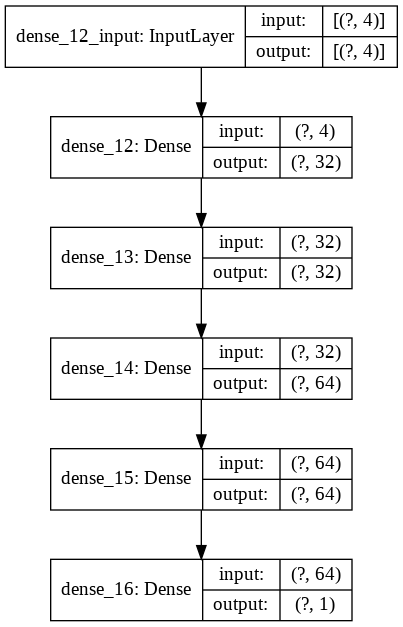

In [26]:
keras.utils.plot_model(model, 'Cooling Tower NN Model.png',show_shapes=True,show_layer_names=True)

In [27]:
#Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train_dataset, train_label_VFD,
  epochs=EPOCHS, validation_split = 0.25, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [28]:
#Review the progress of the model
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,13.736119,3.362427,20.031607,30.297863,3.841187,30.297863,995
996,24.360399,3.408954,21.882875,32.783253,4.028235,32.783253,996
997,13.266759,3.349180,19.196726,51.490444,5.284398,51.490444,997
998,20.759371,4.273314,30.649551,46.684547,4.896133,46.684547,998
999,26.381378,3.662060,23.320490,26.701227,3.532017,26.701227,999


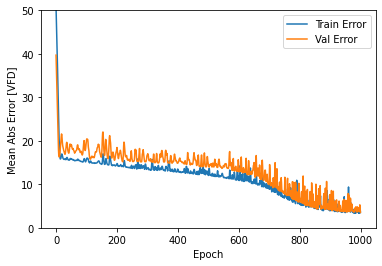

In [29]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [VFD]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,50])
  plt.legend()

  #plt.figure()
  #plt.xlabel('Epoch')
  #plt.ylabel('Mean Square Error [VFD]')
  #plt.plot(hist['epoch'], hist['mse'],
   #        label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mse'],
   #        label = 'Val Error')
  #plt.ylim([0,1000])
  #plt.legend()
  #plt.show()


plot_history(history)

In [30]:
test_predictions = model.predict(test_dataset).flatten()
print(test_predictions)
print(test_label_VFD)

[70.72409  56.813133 82.16294  66.756744 73.06439  35.79916  58.981804
 53.637993 78.622086 64.31949  58.867268 39.352024 47.444225 72.64157
 61.72864  78.622086 72.6335   72.52167  66.89232  58.981804 48.267666
 47.030434]
9      70.00
12     55.00
21     85.00
36     72.40
39     74.10
44     34.48
46     61.04
47     56.81
58     87.79
64     63.87
65     59.46
67     35.21
70     47.60
81     70.85
83     61.01
87     67.16
88     59.05
95     75.73
96     69.80
98     61.04
103    46.69
105    45.39
Name: VFD, dtype: float64


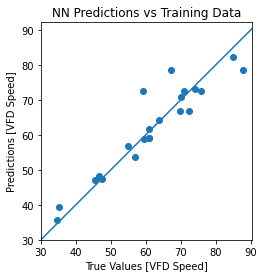

In [31]:
plt.scatter(test_label_VFD, test_predictions)
plt.xlabel('True Values [VFD Speed]')
plt.ylabel('Predictions [VFD Speed]')
plt.axis('equal')
plt.axis('square')
plt.title('NN Predictions vs Training Data')
plt.xlim([30,plt.xlim()[1]])
plt.ylim([30,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig('myimage.png', format='png', dpi=1200)

In [32]:
slope, intercept, r_value, p_value, std_err = stats.linregress(test_predictions,test_label_VFD)
print(r_value**2)

0.8780439499503531


In [0]:
#Save the model
model.save('Cooling_Tower_NN.h5') 

In [36]:
plt.savefig('myimage.png', format='png', dpi=1200)

<Figure size 432x288 with 0 Axes>